In [2]:
import tensorflow as tf

In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."

Num GPUs Available: 1


In [4]:
import tensorflow as tf
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Multiply, Reshape, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import random
# from keras_flops import get_flops


# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
INITIAL_LR = 0.001
EPOCHS = 100
SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/test'

datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes

Found 14219 images belonging to 43 classes.
Found 11955 images belonging to 43 classes.
Found 11958 images belonging to 43 classes.


In [8]:
# CBAM Attention Module
def channel_attention(input_feature, ratio=8, name=''):
    channel = input_feature.shape[-1]
    
    # Global Average Pooling
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = Dense(channel // ratio, activation='relu', name=f'{name}_ca_fc1_avg')(avg_pool)
    avg_pool = Dense(channel, name=f'{name}_ca_fc2_avg')(avg_pool)
    
    # Global Max Pooling
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = Dense(channel // ratio, activation='relu', name=f'{name}_ca_fc1_max')(max_pool)
    max_pool = Dense(channel, name=f'{name}_ca_fc2_max')(max_pool)
    
    cbam_feature = tf.keras.layers.Add()([avg_pool, max_pool])
    cbam_feature = tf.keras.layers.Activation('sigmoid')(cbam_feature)
    
    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature, name=''):
    # Average pooling across channels
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature)
    # Max pooling across channels
    max_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature)
    
    concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])
    cbam_feature = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid', name=f'{name}_sa_conv')(concat)
    
    return Multiply()([input_feature, cbam_feature])

def cbam_block(input_feature, ratio=8, name=''):
    cbam_feature = channel_attention(input_feature, ratio, name=name)
    cbam_feature = spatial_attention(cbam_feature, name=name)
    return cbam_feature

In [10]:
base_model = EfficientNetV2B0(
    include_top=False, 
    weights='imagenet', 
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = True

# Apply CBAM after base model
x = cbam_block(base_model.output, ratio=8, name='cbam')
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(512, activation='gelu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(128, activation='gelu')(x)

output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)


optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR, 
    weight_decay=0.01
)

print("Compiling model...")
model.compile(
    optimizer=optimizer,
    loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


I0000 00:00:1759513092.715256      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Compiling model...


In [11]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")


Model Summary:
Total parameters: 7,470,622
Trainable parameters: 7,408,990


In [12]:
checkpoint_cb = ModelCheckpoint(
    "best_EfficientNetV2B0_CBAM_GELU.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10, 
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]

print("EfficientNetV2B0 + CBAM + GELU Starting training")
!curl -d "EfficientNetV2B0 + CBAM + GELU Starting training" ntfy.sh/model_complete

# Train the whole model on your dataset
history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    verbose=1
)

print("EfficientNetV2B0 + CBAM + GELU Training completed!")
!curl -d "EfficientNetV2B0 + CBAM + GELU Train Complete" ntfy.sh/model_complete

with open('training_history.json', 'w') as f:
    json.dump(history.history,f)
    

EfficientNetV2B0 + CBAM + GELU Starting training
{"id":"VGYizTEOolvt","time":1759513105,"expires":1759556305,"event":"message","topic":"model_complete","message":"EfficientNetV2B0 + CBAM + GELU Starting training"}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1759513177.247388     139 service.cc:148] XLA service 0x7faadc015870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759513177.248354     139 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759513183.498549     139 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1759513194.271314     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759513194.456164     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759513194.643494     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759513194.8308

  1/445 ━━━━━━━━━━━━━━━━━━━━ 13:59:17 113s/step - accuracy: 0.0312 - loss: 4.4213

I0000 00:00:1759513219.534277     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 87/445 ━━━━━━━━━━━━━━━━━━━━ 1:12 202ms/step - accuracy: 0.1456 - loss: 3.6738

E0000 00:00:1759513250.353019     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759513250.536260     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759513250.960230     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759513251.165866     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.3216 - loss: 2.7995
Epoch 1: val_accuracy improved from -inf to 0.08657, saving model to best_EfficientNetV2B0_CBAM_GELU.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 321s 469ms/step - accuracy: 0.3219 - loss: 2.7982 - val_accuracy: 0.0866 - val_loss: 3.5078 - learning_rate: 0.0010
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7082 - loss: 1.4801
Epoch 2: val_accuracy did not improve from 0.08657
445/445 ━━━━━━━━━━━━━━━━━━━━ 90s 203ms/step - accuracy: 0.7082 - loss: 1.4799 - val_accuracy: 0.0698 - val_loss: 3.9586 - learning_rate: 0.0010
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8195 - loss: 1.1947
Epoch 3: val_accuracy did not improve from 0.08657
445/445 ━━━━━━━━━━━━━━━━━━━━ 92s 208ms/step - accuracy: 0.8195 - loss: 1.1947 - val_accuracy: 0.0373 - val_loss: 4.4659 - learning_rate: 0.0010
Epoch 4/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8739 - loss: 1.0655
Epoch 4: val_accu

374/374 ━━━━━━━━━━━━━━━━━━━━ 118s 296ms/step
Test Loss: 0.8460
Test Accuracy: 0.9569
Precision: 0.9357
Recall: 0.9394
F1 Score: 0.9368
Parameters: 7470622


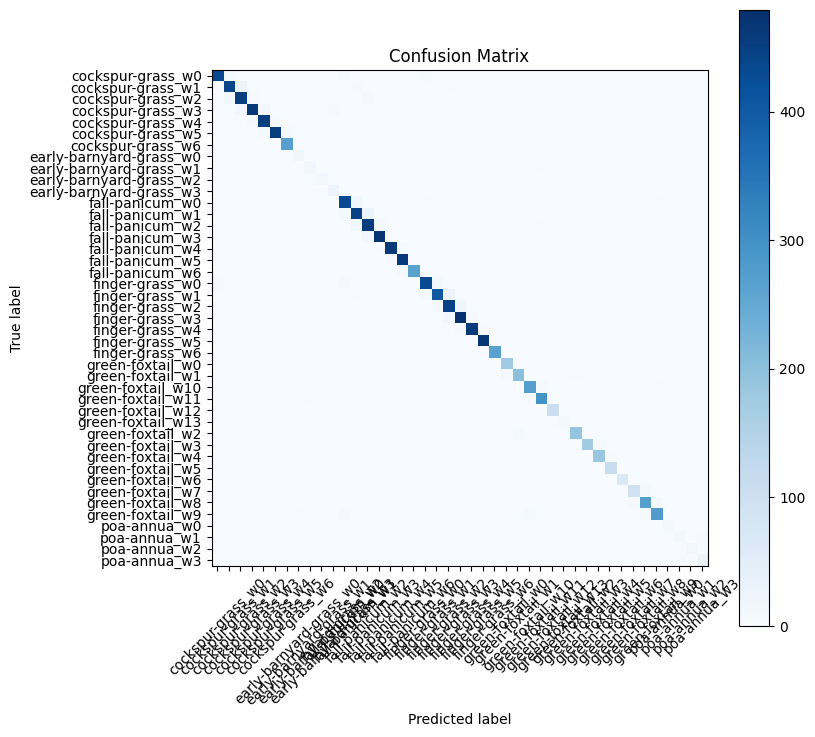

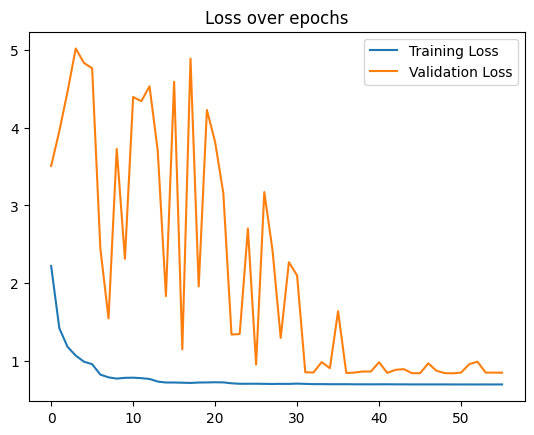

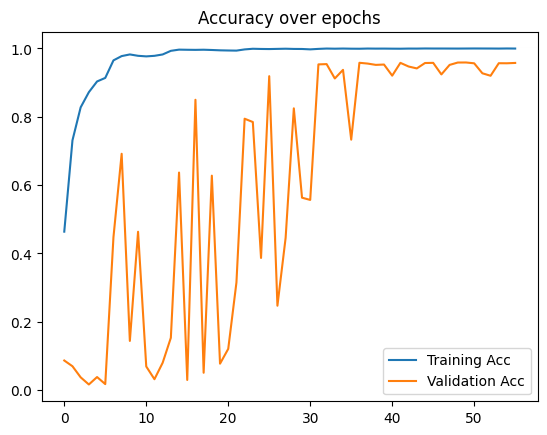

In [13]:
test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Precision, Recall, F1 (macro avg)
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]

# GFLOPS & Params
# flops = get_flops(model, batch_size=1)
num_params = model.count_params()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# print(f"GFLOPS: {flops/1e9:.4f}")
print(f"Parameters: {num_params}")

# Confusion Matrix 
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Loss/Accuracy Curves 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(); plt.title("Loss over epochs"); plt.show()
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend(); plt.title("Accuracy over epochs"); plt.show()


In [14]:
model.save('efficientnet_cbam_gelu_final.keras')
model.save_weights('efficientnet_cbam_gelu_final.weights.h5')

| Model                          |   Params |   Test Loss |   Test Acc |   Precision |   Recall |     F1 |
|:-------------------------------|---------:|------------:|-----------:|------------:|---------:|-------:|
| EfficientNetV2B0 + CBAM + GELU |  7470622 |       0.846 |     0.9569 |      0.9357 |   0.9394 | 0.9368 |


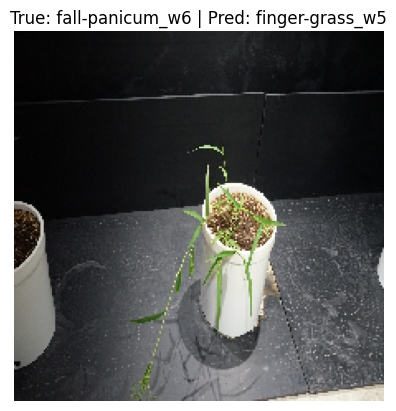

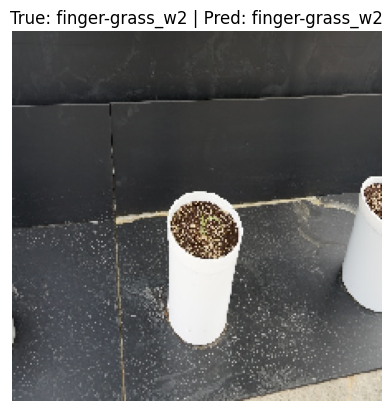

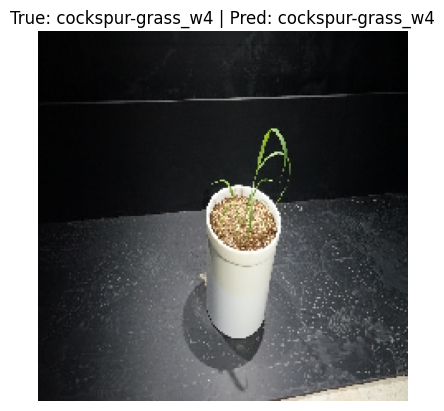

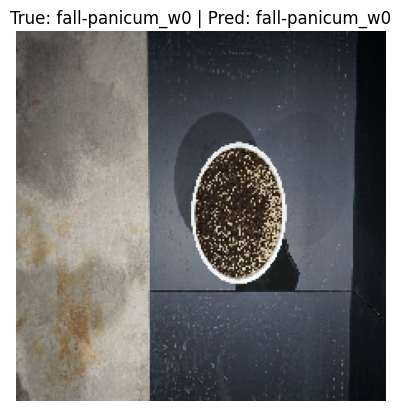

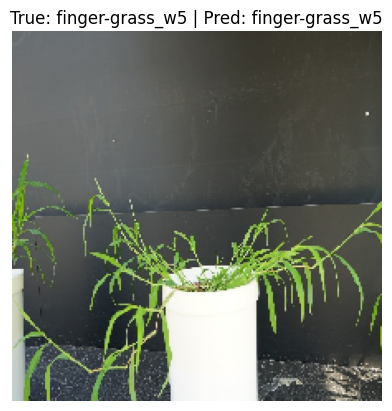

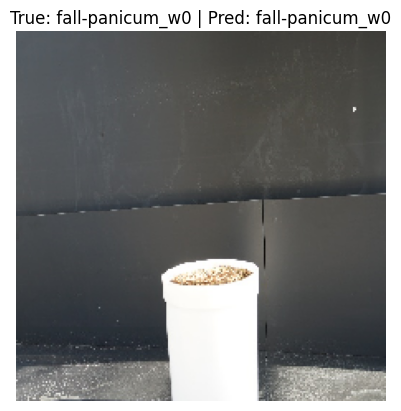

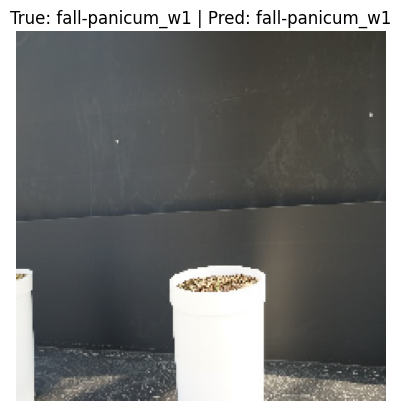

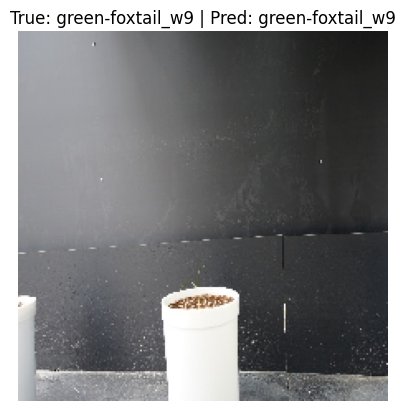

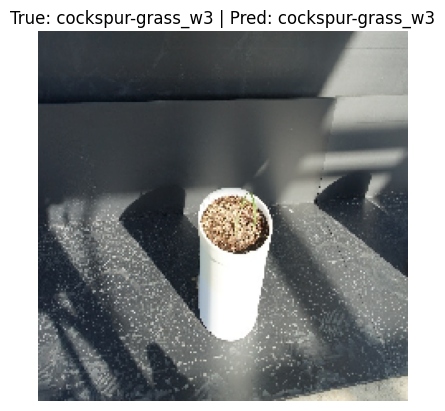

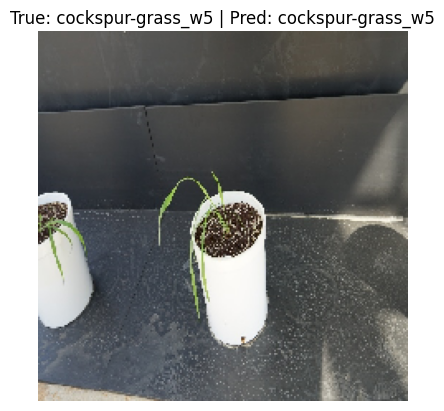

{"id":"nLcPD0yani9e","time":1759518717,"expires":1759561917,"event":"message","topic":"model_complete","message":"CBAM Model Finished"}


In [15]:
import pandas as pd
results = {
    "Model": ["EfficientNetV2B0 + CBAM + GELU"],
    "Params": [num_params],
    # "GFLOPS": [f"{flops/1e9:.4f}"],
    "Test Loss": [f"{test_loss:.4f}"],
    "Test Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"]
}
df = pd.DataFrame(results)
print(df.to_markdown(index=False))


import random
sample_idx = random.sample(range(test_flow.n), 10)
for idx in sample_idx:
    img_path = test_flow.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    true_label = target_names[y_true[idx]]
    pred_label = target_names[y_pred[idx]]
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

!curl -d "CBAM Model Finished" ntfy.sh/model_complete